# start

In [1]:
 # https://github.com/earlew/pwp_python_00
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cmocean.cm as cmo
import matplotlib.dates as mdates
from tqdm.notebook import tqdm
from matplotlib.gridspec import GridSpec
import matplotlib.colors as cl


In [2]:
def rolling_(df):
    lol=pd.DataFrame(df).interpolate(limit=5, axis=1).interpolate(limit=5, axis=0).rolling(1, center=True, axis=1).mean()
    return lol.to_numpy()


def grid2d(x, y, v, xi=1, yi=1, fn='median'):
    if np.size(xi) == 1:
        xi = np.arange(np.nanmin(x), np.nanmax(x)+xi, xi)
    if np.size(yi) == 1:
        yi = np.arange(np.nanmin(y), np.nanmax(y)+yi, yi)

    raw = pd.DataFrame({'x':x,'y':y,'v':v}).dropna()

    grid = np.full([np.size(yi),np.size(xi)], np.nan)
    
    raw['xbins'],xbin_iter = pd.cut(raw.x, xi,retbins=True,labels=False)
    raw['ybins'],ybin_iter = pd.cut(raw.y, yi,retbins=True,labels=False)

    _tmp = raw.groupby(['xbins','ybins'])['v'].agg(fn)
    grid[_tmp.index.get_level_values(1).astype(int),_tmp.index.get_level_values(0).astype(int)] = _tmp.values

    XI,YI = np.meshgrid(xi, yi, indexing='ij')
    return rolling_(grid),XI.T,YI.T

import gsw
import glidertools as gt


ds_bath=xr.open_dataset('/home/jupyter-estelfont/scratch/estel/datasets/bathymetry/gebco_2024_n35.0_s-10.0_w25.0_e85.0.nc')

# functions_

In [3]:
## GRID 3d 4d
GS=1
latt=np.arange(-5,30+GS,GS)
lonn=np.arange(30,80+GS,GS)
# grid 3d for 3d variables (2d + time)

## GRID 3d 4d
# def mode_func(array):

def grid_lat_3df(dsgpd_ln,gs=GS):
    lat_min = (-5)
    lat_max = (30)
    lat = np.arange(lat_min,lat_max+gs,gs)
    lat_labels = np.arange(0,(1/gs)*(lat_max-lat_min),1)
    # lat_labels = range(0,lat_max-lat_min,gs)
    
    return dsgpd_ln.groupby_bins('latitude_f',lat,
                       labels=lat_labels,
                       restore_coord_dims=True).median(skipna=True) #,dim='profile_num')
    
def grid_lon_3d_f(dsgpd_t,gs=GS):
    # define lon min and max resp
    lon_min = 30
    lon_max = 80
    lon = np.arange(lon_min,lon_max+gs,gs)
    lon_labels = np.arange(0,(1/gs)*(lon_max-lon_min),1)
    # lon_labels = range(0,lon_max-lon_min,gs)

    return dsgpd_t.groupby_bins('longitude_f',lon,
                       labels=lon_labels,
                       restore_coord_dims=True).apply(grid_lat_3df)
    
    
def grid_var_3dflt(dsvar,clim='month',gs=GS):
    """for gridding spatially in 2D and time (3D)."""
    if clim == 'climat':
        var = dsvar.groupby_bins(group='time_f.month',bins=range(0,15,3),labels=range(0,4)).apply(grid_lon_3d_f)
    else:
        var = dsvar.groupby('time_f.'+clim).apply(grid_lon_3d_f)
    return var


# grid 3d for 3d variables (2d + time)
def grid_lat_3dfsum(dsgpd_ln,gs=GS):
    lat_min = (-5)
    lat_max = (30)
    lat = np.arange(lat_min,lat_max+gs,gs)
    lat_labels = np.arange(0,(1/gs)*(lat_max-lat_min),1)    
    return dsgpd_ln.groupby_bins('latitude_f',lat,
                       labels=lat_labels,
                       restore_coord_dims=True).count() #,dim='profile_num')
    
def grid_lon_3d_fsum(dsgpd_t,gs=GS):
    # define lon min and max resp
    lon_min = 30
    lon_max = 80
    lon = np.arange(lon_min,lon_max+gs,gs)
    lon_labels = np.arange(0,(1/gs)*(lon_max-lon_min),1)
    # lon_labels = range(0,lon_max-lon_min,gs)

    return dsgpd_t.groupby_bins('longitude_f',lon,
                       labels=lon_labels,
                       restore_coord_dims=True).apply(grid_lat_3dfsum)
    
    
def grid_var_3dfltsum(dsvar,clim='month',gs=GS):
    """for gridding spatially in 2D and time (3D)."""
    var = dsvar.groupby('time_f.'+clim).apply(grid_lon_3d_fsum)
    return var


#####333

##  Load variables

In [4]:
# df_mwt=ds_get_float_pwp_1D('mw_thickness')
df_mwt=xr.open_dataset('/home/jupyter-estelfont/MWL_chapter/data/subselected_variables_argo/thickness_mw.nc')# df_mwt=ds_get_float_pwp_1D('mw_thickness')
df_mw_top=xr.open_dataset('/home/jupyter-estelfont/MWL_chapter/data/subselected_variables_argo/top_mw.nc')# df_mwt=ds_get_float_pwp_1D('mw_thickness')
df_mw_bot=xr.open_dataset('/home/jupyter-estelfont/MWL_chapter/data/subselected_variables_argo/bot_mw.nc')

In [5]:
df_presence=xr.open_dataset('/home/jupyter-estelfont/MWL_chapter/data/subselected_variables_argo/presence_mw.nc')
df_presence=df_presence.sortby('platform_num_f')

df_presence['lat_pp']=df_presence.latitude_f.mean('time_f')
df_presence['lon_pp']=df_presence.longitude_f.mean('time_f')

## only foramtion
dff_presence_1 = df_presence.where(df_presence != 0, np.nan)
dff_presence_1 = dff_presence_1.where(df_presence != 2, np.nan)

## only duration
dff_presence_2 = df_presence.where(df_presence != 0, np.nan)
dff_presence_2 = dff_presence_2.where(df_presence != 1, np.nan)
dff_presence_2 = dff_presence_2.where(df_presence !=2, 1)

# no mode water
dff_presence_0 = df_presence.where(df_presence != 1, np.nan)
dff_presence_0 = dff_presence_0.where(df_presence != 2, np.nan)
dff_presence_0 = dff_presence_0.where(df_presence!=0, 1)

In [6]:
mask_pres=((dff_presence_0.presence_mwl_f.fillna(0).values+dff_presence_1.presence_mwl_f.fillna(0).values)==1).astype(float)
mask_pres[mask_pres==0]=np.nan

mask_thic=(df_mwt.mw_thickness_f>10).values.astype(float)
mask_thic[mask_thic==0]=np.nan

## Gridding

### FLOAT

In [7]:
#thicnkess
df_mwt=df_mwt.set_coords(['latitude_f', 'longitude_f'])
#month
df_grid_mwt_f_month=grid_var_3dflt(df_mwt.mw_thickness_f*mask_thic*mask_pres, clim='month', gs=1) ##3min
#season
df_grid_mwt_f_season=grid_var_3dflt(df_mwt.mw_thickness_f*mask_thic*mask_pres, clim='season', gs=1) ##3min

In [8]:
## presence
#season
dff_presence_1=dff_presence_1.set_coords(['latitude_f', 'longitude_f'])
dff_presence_1_f_grid_sum=grid_var_3dfltsum(dff_presence_1.presence_mwl_f, clim='season', gs=1)
dff_presence_2=dff_presence_2.set_coords(['latitude_f', 'longitude_f'])
dff_presence_2_f_grid_sum=grid_var_3dfltsum(dff_presence_2.presence_mwl_f, clim='season', gs=1) 
dff_presence_0=dff_presence_0.set_coords(['latitude_f', 'longitude_f'])
dff_presence_0_f_grid_sum=grid_var_3dfltsum(dff_presence_0.presence_mwl_f, clim='season', gs=1) 

percentage0_seas=dff_presence_0_f_grid_sum/(dff_presence_1_f_grid_sum+dff_presence_2_f_grid_sum+dff_presence_0_f_grid_sum)
percentage1_seas=dff_presence_1_f_grid_sum/(dff_presence_1_f_grid_sum+dff_presence_2_f_grid_sum+dff_presence_0_f_grid_sum)
percentage2_seas=dff_presence_2_f_grid_sum/(dff_presence_1_f_grid_sum+dff_presence_2_f_grid_sum+dff_presence_0_f_grid_sum)

#month
dff_presence_1=dff_presence_1.set_coords(['latitude_f', 'longitude_f'])
dff_presence_1_f_grid_sum=grid_var_3dfltsum(dff_presence_1.presence_mwl_f, clim='month', gs=1) ##3min
dff_presence_2=dff_presence_2.set_coords(['latitude_f', 'longitude_f'])
dff_presence_2_f_grid_sum=grid_var_3dfltsum(dff_presence_2.presence_mwl_f, clim='month', gs=1) ##3min
dff_presence_0=dff_presence_0.set_coords(['latitude_f', 'longitude_f'])
dff_presence_0_f_grid_sum=grid_var_3dfltsum(dff_presence_0.presence_mwl_f, clim='month', gs=1) ##3min

percentage0_mn=dff_presence_0_f_grid_sum/(dff_presence_1_f_grid_sum+dff_presence_2_f_grid_sum+dff_presence_0_f_grid_sum)
percentage1_mn=dff_presence_1_f_grid_sum/(dff_presence_1_f_grid_sum+dff_presence_2_f_grid_sum+dff_presence_0_f_grid_sum)
percentage2_mn=dff_presence_2_f_grid_sum/(dff_presence_1_f_grid_sum+dff_presence_2_f_grid_sum+dff_presence_0_f_grid_sum)


## masking! --where there is data
msk=np.isfinite((percentage0_mn+percentage1_mn+percentage2_mn)).astype(float)
msk=msk.where(msk!=0, np.nan)
# msk
mskki=((percentage0_mn+percentage1_mn)>0.5).astype(float).values
mskki[mskki==0]=np.nan
# msk
mskki2=(df_grid_mwt_f_month>10).astype(float).values
mskki2[mskki2==0]=np.nan

mwt_msk_per_month=df_grid_mwt_f_month*mskki*mskki2*msk.values

In [9]:
df_mw_top=df_mw_top.set_coords(['latitude_f', 'longitude_f'])
#month
df_grid_mwtop_f_month=grid_var_3dflt(df_mw_top.top_mwl_f*mask_thic*mask_pres, clim='month', gs=1) ##3min
#season
df_grid_mwtop_f_season=grid_var_3dflt(df_mw_top.top_mwl_f*mask_thic*mask_pres, clim='season', gs=1) ##3min

df_mw_bot=df_mw_bot.set_coords(['latitude_f', 'longitude_f'])
#month
df_grid_mwbot_f_month=grid_var_3dflt(df_mw_bot.bot_mwl_f*mask_thic*mask_pres, clim='month', gs=1) ##3min
#season
df_grid_mwbot_f_season=grid_var_3dflt(df_mw_bot.bot_mwl_f*mask_thic*mask_pres, clim='season', gs=1) ##3min

## hasking for 3 profiles/detections

df_grid_mwtop_f_month_count=grid_var_3dfltsum(df_mw_top.top_mwl_f*mask_thic*mask_pres, clim='season', gs=1) ##3min

mask_winter1=df_grid_mwtop_f_month_count.where(df_grid_mwtop_f_month_count!=0, np.nan)
mask_winter=mask_winter1.where(mask_winter1<3, np.nan)

crosseshatches=[mask_winter[0], mask_winter[2], mask_winter[1], mask_winter[3]]

In [10]:
### TRENDS of upper and bottom boundary per season

msk1=np.isfinite(df_grid_mwtop_f_month).astype(float)
msk1=msk1.where(msk1!=0, np.nan)
df_rol_top=df_grid_mwtop_f_month.interpolate_na(dim='longitude_f_bins', method='linear', fill_value="extrapolate",limit=3).interpolate_na(dim='latitude_f_bins',fill_value="extrapolate", method='linear', limit=3).rolling(longitude_f_bins=3, center=True).mean().rolling(latitude_f_bins=3, center=True).mean()*msk1
extra=(df_rol_top)[0]
extra['month']=13
df_grid_mwtop_f_month_diff=xr.concat([df_rol_top, extra], dim='month').diff('month').fillna(0)
df_grid_mwtop_difference_season=[xr.concat([df_grid_mwtop_f_month_diff[10:],df_grid_mwtop_f_month_diff[0:1]], dim='month').sum('month'),df_grid_mwtop_f_month_diff[1:4].sum('month'),df_grid_mwtop_f_month_diff[4:7].sum('month'),df_grid_mwtop_f_month_diff[7:10].sum('month')]

msk1=np.isfinite(df_grid_mwbot_f_month).astype(float)
msk1=msk1.where(msk1!=0, np.nan)
df_rol_bot=df_grid_mwbot_f_month.interpolate_na(dim='longitude_f_bins', method='linear', fill_value="extrapolate",limit=3).interpolate_na(dim='latitude_f_bins',fill_value="extrapolate", method='linear', limit=3).rolling(longitude_f_bins=3, center=True).mean().rolling(latitude_f_bins=3, center=True).mean()*msk1
extra=(df_rol_bot)[0]
extra['month']=13
df_grid_mwbot_f_month_dif=xr.concat([df_rol_bot, extra], dim='month').diff('month').fillna(0)
df_grid_mwbot_difference_season=[xr.concat([df_grid_mwbot_f_month_dif[10:],df_grid_mwbot_f_month_dif[0:1]], dim='month').sum('month'),df_grid_mwbot_f_month_dif[1:4].sum('month'),df_grid_mwbot_f_month_dif[4:7].sum('month'),df_grid_mwbot_f_month_dif[7:10].sum('month')]


#### Figure 5

In [11]:
letters = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
alp=0.5

from matplotlib.colors import LinearSegmentedColormap
def get_cmap():
    """
    Create and return a custom colormap for visualizations.

    This function generates a linear segmented colormap that transitions through a specified 
    set of colors, ordered from dark red to dark blue. The colormap is defined using 
    hexadecimal color codes and is intended for use in visualizations where a smooth 
    transition between these colors is desired.

    Returns
    -------
    cmap : matplotlib.colors.LinearSegmentedColormap
        A custom colormap object that can be used in plotting functions to map data values 
        to colors.

    Notes
    -----
    - The colormap transitions through the following colors (in reverse order for the final colormap):
      '#053061', '#2166ac', '#4393c3', '#92c5de', '#d1e5f0', '#f7f7f7', 
      '#fddbc7', '#f4a582', '#d6604d', '#b2182b', '#67001f'.
    - The resulting colormap can be applied to any data visualization that supports colormaps, 
      such as those created with matplotlib.
    
    Example
    -------
    >>> cmap = get_cmap()
    >>> plt.imshow(data, cmap=cmap)
    >>> plt.colorbar()
    """
    
    # Define the colors in the order you've specified
    colors = ['#67001f', '#b2182b', '#d6604d', '#f4a582', '#fddbc7', '#f7f7f7', '#d1e5f0', '#92c5de', '#4393c3', '#2166ac', '#053061']
    # Create a colormap that transitions from the first color to the last
    cmap_name = 'custom_cmap'
    cmap = LinearSegmentedColormap.from_list('custom_cmap', colors[::-1])
    return cmap

br=get_cmap()

0it [00:00, ?it/s]

/tmp/ipykernel_645893/3405609349.py:29: UserWarning: The following kwargs were not used by contour: 'lw'
  ax.contour(ds_bath.lon[::200],ds_bath.lat[::200], ds_bath.elevation[::200, ::200],  levels=[0], colors='k', lw=1)


(60.05291005291005, 7.476525603126247)
(50.74276020840906, 5.433907372358346)


/tmp/ipykernel_645893/3405609349.py:29: UserWarning: The following kwargs were not used by contour: 'lw'
  ax.contour(ds_bath.lon[::200],ds_bath.lat[::200], ds_bath.elevation[::200, ::200],  levels=[0], colors='k', lw=1)


(27.777777777777768, 5.989703098641581)
(45.84146763586016, 9.51455026679092)


0it [00:00, ?it/s]

/tmp/ipykernel_645893/3405609349.py:78: UserWarning: The following kwargs were not used by contour: 'lw'
  ax.contour(ds_bath.lon[::200],ds_bath.lat[::200], ds_bath.elevation[::200, ::200],  levels=[0], colors='k', lw=1)
/tmp/ipykernel_645893/3405609349.py:78: UserWarning: The following kwargs were not used by contour: 'lw'
  ax.contour(ds_bath.lon[::200],ds_bath.lat[::200], ds_bath.elevation[::200, ::200],  levels=[0], colors='k', lw=1)


0it [00:00, ?it/s]

/tmp/ipykernel_645893/3405609349.py:110: UserWarning: The following kwargs were not used by contour: 'lw'
  ax.contour(ds_bath.lon[::200],ds_bath.lat[::200], ds_bath.elevation[::200, ::200],  levels=[0], colors='k', lw=1)


(84.25573192239858, 7.1694121749057445)
(71.0592309867119, 6.595994704919638)


/tmp/ipykernel_645893/3405609349.py:110: UserWarning: The following kwargs were not used by contour: 'lw'
  ax.contour(ds_bath.lon[::200],ds_bath.lat[::200], ds_bath.elevation[::200, ::200],  levels=[0], colors='k', lw=1)


(43.66666666666666, 8.022345336082077)
(65.91519556940116, 11.384341027419456)


0it [00:00, ?it/s]

/tmp/ipykernel_645893/3405609349.py:165: UserWarning: The following kwargs were not used by contour: 'lw'
  ax.contour(ds_bath.lon[::200],ds_bath.lat[::200], ds_bath.elevation[::200, ::200],  levels=[0], colors='k', lw=1)
/tmp/ipykernel_645893/3405609349.py:165: UserWarning: The following kwargs were not used by contour: 'lw'
  ax.contour(ds_bath.lon[::200],ds_bath.lat[::200], ds_bath.elevation[::200, ::200],  levels=[0], colors='k', lw=1)


0it [00:00, ?it/s]

/tmp/ipykernel_645893/3405609349.py:219: UserWarning: The following kwargs were not used by contour: 'lw'
  ax.contour(ds_bath.lon[::200],ds_bath.lat[::200], ds_bath.elevation[::200, ::200],  levels=[0], colors='k', lw=1)


(-14.927777777777758, 4.5905349517553855)
(-9.70420760558304, 4.606924091997484)


/tmp/ipykernel_645893/3405609349.py:219: UserWarning: The following kwargs were not used by contour: 'lw'
  ax.contour(ds_bath.lon[::200],ds_bath.lat[::200], ds_bath.elevation[::200, ::200],  levels=[0], colors='k', lw=1)


(-2.732986111111103, 1.2761722426029694)
(-6.570669659558543, 4.175462303188711)


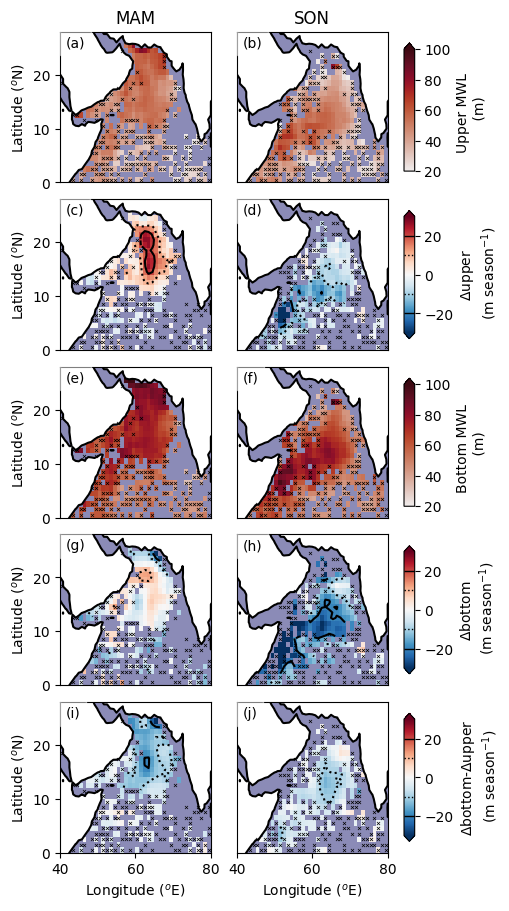

In [12]:
xx,yy=10,8

fig = plt.figure(figsize=(8, 9), constrained_layout=True)
gs = GridSpec(xx,yy, figure=fig)
titles=df_grid_mwt_f_season.season.values
axis_=[]

msk_availability_data_season=np.isfinite((percentage0_seas+percentage1_seas)).astype(float)
msk_availability_data_season=((percentage0_seas+percentage1_seas)>0).astype(float)
cmap_data_availability_ = cl.ListedColormap(['midnightblue', 'midnightblue'])

msk1=np.isfinite(df_grid_mwtop_f_season).astype(float)
msk1=msk1.where(msk1!=0, np.nan)
df_plt=df_grid_mwtop_f_season.interpolate_na(dim='longitude_f_bins', method='linear', fill_value="extrapolate",limit=3).interpolate_na(dim='latitude_f_bins',fill_value="extrapolate", method='linear', limit=3).rolling(longitude_f_bins=3, center=True).mean().rolling(latitude_f_bins=3, center=True).mean()*msk1

for i,m in tqdm(enumerate([2,3])):
    ax = fig.add_subplot(gs[0:2, i*2:i*2+2])
    plt.title(titles[m])
    t=ax.text(x=.04,y=.9,s="(" + letters[i] + ')',transform=ax.transAxes)
    t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))
    mskk_availability_data_m=msk_availability_data_season.isel(season=m)

    ax.pcolormesh(lonn, latt, (mskk_availability_data_m.where(mskk_availability_data_m==0, 0)).T, cmap=cmap_data_availability_, alpha=0.5)
    

    axis_.append(ax)
    cb1=plt.pcolormesh( lonn, latt, df_plt[m].T.values, vmin=20, vmax=100, cmap=cmo.amp)

    ax.contour(ds_bath.lon[::200],ds_bath.lat[::200], ds_bath.elevation[::200, ::200],  levels=[0], colors='k', lw=1)
    ax.contourf(ds_bath.lon[::200],ds_bath.lat[::200], ds_bath.elevation[::200, ::200],  levels=[0, 3000], colors='w')
    ax.set_xlim(40,80)
    ax.set_ylim(0,28)
    if m==2:
        lol=1
    elif m==3:
        lol=3
    mask_hatches=crosseshatches[lol]
    non_nan_coords = mask_hatches.stack(z=("latitude_f_bins", "longitude_f_bins")).dropna("z")
    y_points, x_points=non_nan_coords['latitude_f_bins'].values.astype(int), non_nan_coords['longitude_f_bins'].values.astype(int)
    for i, j in zip(x_points, y_points):
        # print(x[i])
        plt.scatter( lonn[i]+GS/2,latt[j]+GS/2, s=5,marker='x', c='k', linewidth=0.5)

    mskss=(~np.isfinite(crosseshatches[lol]/crosseshatches[lol])).astype(float).where((~np.isfinite(crosseshatches[lol]/crosseshatches[lol])).astype(float)==1, np.nan)
    lol1=np.nanmean(((df_plt[m]).to_numpy()*mskss).to_numpy().T[25:,15:-10]),np.nanstd(((df_plt[m]).to_numpy()*mskss).to_numpy().T[25:, 15:-10])
    lol2=np.nanmean(((df_plt[m]).to_numpy()*mskss).to_numpy().T[15:25,15:-10]),np.nanstd(((df_plt[m]).to_numpy()*mskss).to_numpy().T[15:25,15:-10])
    print(lol1)
    print(lol2)
    
cbar = plt.colorbar(cb1,extend='max', shrink=0.85, aspect=12)
cbar.set_label('Upper MWL \n (m)')

for i,m in tqdm(enumerate([1,3])):
    ax = fig.add_subplot(gs[2:4, i*2:i*2+2])
    t=ax.text(x=.04,y=.9,s="(" + letters[i+2] + ')',transform=ax.transAxes)
    t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))
    if m==1:
        lol=2
    elif m==3:
        lol=3
    mskk_availability_data_m=msk_availability_data_season.isel(season=lol)
    ax.pcolormesh(lonn, latt, (mskk_availability_data_m).T, cmap=cmap_data_availability_, alpha=0.5)

    axis_.append(ax)

    pltlol=df_grid_mwtop_difference_season[m]
    pltlol=pltlol.where(pltlol!=0, np.nan) ## nans
    
    msk1=np.isfinite(pltlol).astype(float)  
    msk1=msk1.where(msk1!=0, np.nan)
    to_p2=df_grid_mwtop_difference_season[m]

    dss_interp=pd.DataFrame((to_p2.values)).interpolate(axis=0, limit_direction='both', limit=5).interpolate(axis=1, limit_direction='both', limit=5).rolling( 3,axis=1, center=True).mean().rolling(3, axis=0,center=True).mean()*(msk1.values)

    cb3=plt.pcolormesh( lonn, latt, dss_interp.T, vmin=-30, vmax=30, cmap=br)
    plt.contour( lonn[:-1]+GS/2, latt[:-1]+GS/2, dss_interp.T, levels=[-20,-10,10,20], colors='k', linestyles=['solid', ':', ':', 'solid'])
    
    ax.contour(ds_bath.lon[::200],ds_bath.lat[::200], ds_bath.elevation[::200, ::200],  levels=[0], colors='k', lw=1)
    ax.contourf(ds_bath.lon[::200],ds_bath.lat[::200], ds_bath.elevation[::200, ::200],  levels=[0, 3000], colors='w')
    ax.set_xlim(40,80)
    ax.set_ylim(0,28)
    
    mask_hatches=crosseshatches[m]
    non_nan_coords = mask_hatches.stack(z=("latitude_f_bins", "longitude_f_bins")).dropna("z")
    y_points, x_points=non_nan_coords['latitude_f_bins'].values.astype(int), non_nan_coords['longitude_f_bins'].values.astype(int)
    for i, j in zip(x_points, y_points):
        plt.scatter( lonn[i]+GS/2,latt[j]+GS/2, s=5,marker='x', c='k', linewidth=0.5)

cbar = plt.colorbar(cb3,  extend='both', shrink=0.85, aspect=12)
cbar.set_label('$\Delta$upper \n (m season$^{-1}$)')
ax = cbar.ax
xmin, xmax = ax.get_xlim()
ax.hlines([-20,20], xmin, xmax, colors=['black'], linewidth=1)
ax.hlines([-10,10], xmin, xmax, colors=['black'], linestyle=':', linewidth=1)

msk1=np.isfinite(df_grid_mwbot_f_season).astype(float)
msk1=msk1.where(msk1!=0, np.nan)
df_plt=df_grid_mwbot_f_season.interpolate_na(dim='longitude_f_bins', method='linear', fill_value="extrapolate",limit=3).interpolate_na(dim='latitude_f_bins',fill_value="extrapolate", method='linear', limit=3).rolling(longitude_f_bins=3, center=True).mean().rolling(latitude_f_bins=3, center=True).mean()*msk1

for i,m in tqdm(enumerate([2,3])):
    ax = fig.add_subplot(gs[4:6, i*2:i*2+2])
    t=ax.text(x=.04,y=.9,s="(" + letters[i+4] + ')',transform=ax.transAxes)
    t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))
    mskk_availability_data_m=msk_availability_data_season.isel(season=m)
    ax.pcolormesh(lonn, latt, (mskk_availability_data_m).T, cmap=cmap_data_availability_, alpha=0.5)

    axis_.append(ax)
    cb1=plt.pcolormesh( lonn, latt, df_plt[m].T, vmin=20, vmax=100, cmap=cmo.amp)

    ax.contour(ds_bath.lon[::200],ds_bath.lat[::200], ds_bath.elevation[::200, ::200],  levels=[0], colors='k', lw=1)
    ax.contourf(ds_bath.lon[::200],ds_bath.lat[::200], ds_bath.elevation[::200, ::200],  levels=[0, 3000], colors='w')
    ax.set_xlim(40,80)
    ax.set_ylim(0,28)
    
    if m==2:
        lol=1
    elif m==3:
        lol=3
    mask_hatches=crosseshatches[lol]
    non_nan_coords = mask_hatches.stack(z=("latitude_f_bins", "longitude_f_bins")).dropna("z")
    y_points, x_points=non_nan_coords['latitude_f_bins'].values.astype(int), non_nan_coords['longitude_f_bins'].values.astype(int)
    for i, j in zip(x_points, y_points):
        plt.scatter( lonn[i]+GS/2,latt[j]+GS/2, s=5,marker='x', c='k', linewidth=0.5)
        
    mskss=(~np.isfinite(crosseshatches[lol]/crosseshatches[lol])).astype(float).where((~np.isfinite(crosseshatches[lol]/crosseshatches[lol])).astype(float)==1, np.nan)
    lol1=np.nanmean(((df_plt[m]).to_numpy()*mskss).to_numpy().T[25:,15:-10]),np.nanstd(((df_plt[m]).to_numpy()*mskss).to_numpy().T[25:, 15:-10])
    lol2=np.nanmean(((df_plt[m]).to_numpy()*mskss).to_numpy().T[15:25,15:-10]),np.nanstd(((df_plt[m]).to_numpy()*mskss).to_numpy().T[15:25,15:-10])
    print(lol1)
    print(lol2)


cbar = plt.colorbar(cb1,extend='max', shrink=0.85, aspect=12)
cbar.set_label('Bottom MWL \n (m)')
# ax = cbar.ax
# xmin, xmax = ax.get_xlim()
# ax.hlines([-20,20], xmin, xmax, colors=['black'], linewidth=2)
# ax.hlines([-10,10], xmin, xmax, colors=['black'], linestyle=':', linewidth=2)



for i,m in tqdm(enumerate([1,3])):
    ax = fig.add_subplot(gs[6:8, i*2:i*2+2])
    t=ax.text(x=.04,y=.9,s="(" + letters[i+6] + ')',transform=ax.transAxes)
    t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))
    if m==1:
        lol=2
    elif m==3:
        lol=3
    mskk_availability_data_m=msk_availability_data_season.isel(season=lol)
    ax.pcolormesh(lonn, latt, (mskk_availability_data_m).T, cmap=cmap_data_availability_, alpha=0.5)

    axis_.append(ax)

    pltlol=df_grid_mwbot_difference_season[m]
    pltlol=pltlol.where(pltlol!=0, np.nan)
    
    msk1=np.isfinite(pltlol).astype(float)
    msk1=msk1.where(msk1!=0, np.nan)
    dss_interp=pd.DataFrame((pltlol.values)).interpolate(axis=0, limit_direction='both', limit=5).interpolate(axis=1, limit_direction='both', limit=5).rolling( 3,axis=1, center=True).mean().rolling(3, axis=0,center=True).mean()*(msk1.values)

    cb3=plt.pcolormesh( lonn, latt, dss_interp.T, vmin=-30, vmax=30, cmap=br)
    
    plt.contour( lonn[:-1]+GS/2, latt[:-1]+GS/2, dss_interp.T, levels=[-20,-10,10,20], colors='k', linestyles=['solid', ':', ':', 'solid'])
    
    ax.contour(ds_bath.lon[::200],ds_bath.lat[::200], ds_bath.elevation[::200, ::200],  levels=[0], colors='k', lw=1)
    ax.contourf(ds_bath.lon[::200],ds_bath.lat[::200], ds_bath.elevation[::200, ::200],  levels=[0, 3000], colors='w')
    
    ax.set_xlim(40,80)
    ax.set_ylim(0,28)
    mask_hatches=crosseshatches[m]
    
    non_nan_coords = mask_hatches.stack(z=("latitude_f_bins", "longitude_f_bins")).dropna("z")

    y_points, x_points=non_nan_coords['latitude_f_bins'].values.astype(int), non_nan_coords['longitude_f_bins'].values.astype(int)
    for i, j in zip(x_points, y_points):
        plt.scatter( lonn[i]+GS/2,latt[j]+GS/2, s=5,marker='x', c='k', linewidth=0.5)
        
cbar = plt.colorbar(cb3,  extend='both', shrink=0.85, aspect=12)

cbar.set_label('$\Delta$bottom \n (m season$^{-1}$)')
ax = cbar.ax
xmin, xmax = ax.get_xlim()
ax.hlines([-20,20], xmin, xmax, colors=['black'], linewidth=1)
ax.hlines([-10,10], xmin, xmax, colors=['black'], linestyle=':', linewidth=1)



for i,m in tqdm(enumerate([1,3])):
    ax = fig.add_subplot(gs[8:10, i*2:i*2+2])
    t=ax.text(x=.04,y=.9,s="(" + letters[i+8] + ')',transform=ax.transAxes)
    t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))
    if m==1:
        lol=2
    elif m==3:
        lol=3
    mskk_availability_data_m=msk_availability_data_season.isel(season=lol)
    ax.pcolormesh(lonn, latt, (mskk_availability_data_m).T, cmap=cmap_data_availability_, alpha=0.5)

    axis_.append(ax)

    
    pltlol=df_grid_mwtop_difference_season[m]

    pltlol=pltlol.where(pltlol!=0, np.nan)
    msk1=np.isfinite(pltlol).astype(float)
    msk1=msk1.where(msk1!=0, np.nan)
    df_plt_top=pd.DataFrame((pltlol.values)).interpolate(axis=0, limit_direction='both', limit=5).interpolate(axis=1, limit_direction='both', limit=5).rolling( 3,axis=1, center=True).mean().rolling(3, axis=0,center=True).mean()*(msk1.values)

    
    pltlol=df_grid_mwbot_difference_season[m]
    pltlol=pltlol.where(pltlol!=0, np.nan)
    msk1=np.isfinite(pltlol).astype(float)
    msk1=msk1.where(msk1!=0, np.nan)
    df_plt_bot=pd.DataFrame((pltlol.values)).interpolate(axis=0, limit_direction='both', limit=5).interpolate(axis=1, limit_direction='both', limit=5).rolling( 3,axis=1, center=True).mean().rolling(3, axis=0,center=True).mean()*(msk1.values)

    cb3=plt.pcolormesh( lonn, latt, (df_plt_bot-df_plt_top).T, vmin=-30, vmax=30, cmap=br)
    plt.contour( lonn[:-1]+GS/2, latt[:-1]+GS/2, (df_plt_bot-df_plt_top).T, levels=[-20,-10,10,20], colors='k', linestyles=['solid', ':', ':', 'solid'])
    
    ax.contour(ds_bath.lon[::200],ds_bath.lat[::200], ds_bath.elevation[::200, ::200],  levels=[0], colors='k', lw=1)
    ax.contourf(ds_bath.lon[::200],ds_bath.lat[::200], ds_bath.elevation[::200, ::200],  levels=[0, 3000], colors='w')
    ax.set_xlim(40,80)
    ax.set_ylim(0,28)
    
    mask_hatches=crosseshatches[m]
    non_nan_coords = mask_hatches.stack(z=("latitude_f_bins", "longitude_f_bins")).dropna("z")
    y_points, x_points=non_nan_coords['latitude_f_bins'].values.astype(int), non_nan_coords['longitude_f_bins'].values.astype(int)
    for i, j in zip(x_points, y_points):
        plt.scatter( lonn[i]+GS/2,latt[j]+GS/2, s=5,marker='x', c='k', linewidth=0.5)   
        
    ## some stats
    mskss=(~np.isfinite(crosseshatches[m]/crosseshatches[m])).astype(float).where((~np.isfinite(crosseshatches[m]/crosseshatches[m])).astype(float)==1, np.nan)
    lol1=np.nanmean(((df_plt_bot-df_plt_top).to_numpy()*mskss).to_numpy().T[25:,15:-10]),np.nanstd(((df_plt_bot-df_plt_top).to_numpy()*mskss).to_numpy().T[25:, 15:-10])
    lol2=np.nanmean(((df_plt_bot-df_plt_top).to_numpy()*mskss).to_numpy().T[15:25,15:-10]),np.nanstd(((df_plt_bot-df_plt_top).to_numpy()*mskss).to_numpy().T[15:25,15:-10])
    print(lol1)
    print(lol2)


cbar = plt.colorbar(cb3,  extend='both', shrink=0.85, aspect=12)
cbar.set_label('$\Delta$bottom-$\Delta$upper \n (m season$^{-1}$)')
ax = cbar.ax
xmin, xmax = ax.get_xlim()
ax.hlines([-20,20], xmin, xmax, colors=['black'], linewidth=1)
ax.hlines([-10,10], xmin, xmax, colors=['black'], linestyle=':', linewidth=1)



## other settings
axis_[0].set_ylabel('Latitude ($^o$N)')

for i in range(8):
    axis_[i].set_xticks([])

for i in range(1,10,2):
    axis_[i].set_yticks([])

axis_[2].set_ylabel('Latitude ($^o$N)')
axis_[4].set_ylabel('Latitude ($^o$N)')
axis_[6].set_ylabel('Latitude ($^o$N)')
axis_[8].set_ylabel('Latitude ($^o$N)')

for i in range(8, len(axis_)):
    axis_[i].set_xlabel('Longitude ($^o$E)')
    
plt.savefig('Figures/Figure5_TopBottom.png', dpi=600, bbox_inches='tight')

In [15]:
# xx,yy=10,8
# # fig_sx, fig_sy=8,7

# # from matplotlib.gridspec import GridSpec

# fig = plt.figure(figsize=(8, 9), constrained_layout=True)
# gs = GridSpec(xx,yy, figure=fig)
# titles=df_grid_mwt_f_season.season.values
# axis_=[]

# msk_availability_data_season=np.isfinite((percentage0_seas+percentage1_seas)).astype(float)
# msk_availability_data_season=((percentage0_seas+percentage1_seas)>0).astype(float)
# # cmap_data_availability_ = cl.ListedColormap(['white', 'midnightblue'])
# cmap_data_availability_ = cl.ListedColormap(['midnightblue', 'midnightblue'])


# msk1=np.isfinite(df_grid_mwtop_f_season).astype(float)
# msk1=msk1.where(msk1!=0, np.nan)
# df_plt=df_grid_mwtop_f_season.interpolate_na(dim='longitude_f_bins', method='linear', fill_value="extrapolate",limit=3).interpolate_na(dim='latitude_f_bins',fill_value="extrapolate", method='linear', limit=3).rolling(longitude_f_bins=3, center=True).mean().rolling(latitude_f_bins=3, center=True).mean()*msk1


# for i,m in tqdm(enumerate([2,3])):
#     # ax = fig.add_subplot(gs[ i % yy,i // yy])
#     ax = fig.add_subplot(gs[0:2, i*2:i*2+2])
#     plt.title(titles[m])
#     t=ax.text(x=.04,y=.9,s="(" + letters[i] + ')',transform=ax.transAxes)
#     t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))
#     mskk_availability_data_m=msk_availability_data_season.isel(month_bins=i+i+1)
#     # ax.pcolormesh(lonn, latt, (mskk_availability_data_m).T, cmap=cmap_data_availability_, alpha=0.5)
#     ax.pcolormesh(lonn, latt, (mskk_availability_data_m.where(mskk_availability_data_m==0, 0)).T, cmap=cmap_data_availability_, alpha=0.5)
    

#     axis_.append(ax)
#     cb1=plt.pcolormesh( lonn, latt, df_plt[m].T.values, vmin=20, vmax=100, cmap=cmo.amp)

#     ax.contour(ds_bath.lon[::200],ds_bath.lat[::200], ds_bath.elevation[::200, ::200],  levels=[0], colors='k', lw=1)
#     ax.contourf(ds_bath.lon[::200],ds_bath.lat[::200], ds_bath.elevation[::200, ::200],  levels=[0, 3000], colors='w')
#     ax.set_xlim(40,80)
#     ax.set_ylim(0,28)

# cbar = plt.colorbar(cb1,extend='max')
# cbar.set_label('Top MW \n (m)')



# for i,m in tqdm(enumerate([1,3])):
#     # ax = fig.add_subplot(gs[ i % yy,i // yy])
#     ax = fig.add_subplot(gs[2:4, i*2:i*2+2])
#     t=ax.text(x=.04,y=.9,s="(" + letters[i+2] + ')',transform=ax.transAxes)
#     t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))
#     mskk_availability_data_m=msk_availability_data_season.isel(month_bins=m)
#     ax.pcolormesh(lonn, latt, (mskk_availability_data_m).T, cmap=cmap_data_availability_, alpha=0.5)

#     axis_.append(ax)

#     pltlol=df_grid_mwtop_difference_season[m]
#     pltlol=pltlol.where(pltlol!=0, np.nan)
    
#     msk1=np.isfinite(pltlol).astype(float)
#     msk1=msk1.where(msk1!=0, np.nan)
#     to_p2=df_grid_mwtop_difference_season[m]
#     # pltlol=to_p2.where(to_p2!=0, np.nan)
#     dss_interp=pd.DataFrame((to_p2.values)).interpolate(axis=0, limit_direction='both', limit=5).interpolate(axis=1, limit_direction='both', limit=5).rolling( 3,axis=1, center=True).mean().rolling(3, axis=0,center=True).mean()*(msk1.values)

#     cb3=plt.pcolormesh( lonn, latt, dss_interp.T, vmin=-30, vmax=30, cmap=br)
    
#     plt.contour( lonn[:-1]+GS/2, latt[:-1]+GS/2, dss_interp.T, levels=[-20,-10,10,20], colors='k', linestyles=['solid', ':', ':', 'solid'])
    
#     ax.contour(ds_bath.lon[::200],ds_bath.lat[::200], ds_bath.elevation[::200, ::200],  levels=[0], colors='k', lw=1)
#     ax.contourf(ds_bath.lon[::200],ds_bath.lat[::200], ds_bath.elevation[::200, ::200],  levels=[0, 3000], colors='w')
#     ax.set_xlim(40,80)
#     ax.set_ylim(0,28)


# cbar = plt.colorbar(cb3,  extend='both')
# cbar.set_label('$\Delta$top \n (m season$^{-1}$)')



# msk1=np.isfinite(df_grid_mwbot_f_season).astype(float)
# msk1=msk1.where(msk1!=0, np.nan)
# df_plt=df_grid_mwbot_f_season.interpolate_na(dim='longitude_f_bins', method='linear', fill_value="extrapolate",limit=3).interpolate_na(dim='latitude_f_bins',fill_value="extrapolate", method='linear', limit=3).rolling(longitude_f_bins=3, center=True).mean().rolling(latitude_f_bins=3, center=True).mean()*msk1


# for i,m in tqdm(enumerate([2,3])):
#     # ax = fig.add_subplot(gs[ i % yy,i // yy])
#     ax = fig.add_subplot(gs[4:6, i*2:i*2+2])
#     t=ax.text(x=.04,y=.9,s="(" + letters[i+4] + ')',transform=ax.transAxes)
#     t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))
#     mskk_availability_data_m=msk_availability_data_season.isel(month_bins=i+i+1)
#     ax.pcolormesh(lonn, latt, (mskk_availability_data_m).T, cmap=cmap_data_availability_, alpha=0.5)

#     axis_.append(ax)
#     cb1=plt.pcolormesh( lonn, latt, df_plt[m].T, vmin=20, vmax=100, cmap=cmo.amp)

#     ax.contour(ds_bath.lon[::200],ds_bath.lat[::200], ds_bath.elevation[::200, ::200],  levels=[0], colors='k', lw=1)
#     ax.contourf(ds_bath.lon[::200],ds_bath.lat[::200], ds_bath.elevation[::200, ::200],  levels=[0, 3000], colors='w')
#     ax.set_xlim(40,80)
#     ax.set_ylim(0,28)

# cbar = plt.colorbar(cb1,extend='max')
# cbar.set_label('Bot MW \n (m)')



# for i,m in tqdm(enumerate([1,3])):
#     # ax = fig.add_subplot(gs[ i % yy,i // yy])
#     ax = fig.add_subplot(gs[6:8, i*2:i*2+2])
#     t=ax.text(x=.04,y=.9,s="(" + letters[i+6] + ')',transform=ax.transAxes)
#     t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))
#     mskk_availability_data_m=msk_availability_data_season.isel(month_bins=m)
#     ax.pcolormesh(lonn, latt, (mskk_availability_data_m).T, cmap=cmap_data_availability_, alpha=0.5)

#     axis_.append(ax)

#     pltlol=df_grid_mwbot_difference_season[m]
#     pltlol=pltlol.where(pltlol!=0, np.nan)
    
#     msk1=np.isfinite(pltlol).astype(float)
#     msk1=msk1.where(msk1!=0, np.nan)
#     dss_interp=pd.DataFrame((pltlol.values)).interpolate(axis=0, limit_direction='both', limit=5).interpolate(axis=1, limit_direction='both', limit=5).rolling( 3,axis=1, center=True).mean().rolling(3, axis=0,center=True).mean()*(msk1.values)

#     cb3=plt.pcolormesh( lonn, latt, dss_interp.T, vmin=-30, vmax=30, cmap=br)
    
#     plt.contour( lonn[:-1]+GS/2, latt[:-1]+GS/2, dss_interp.T, levels=[-20,-10,10,20], colors='k', linestyles=['solid', ':', ':', 'solid'])
    
#     ax.contour(ds_bath.lon[::200],ds_bath.lat[::200], ds_bath.elevation[::200, ::200],  levels=[0], colors='k', lw=1)
#     ax.contourf(ds_bath.lon[::200],ds_bath.lat[::200], ds_bath.elevation[::200, ::200],  levels=[0, 3000], colors='w')
    
#     ax.set_xlim(40,80)
#     ax.set_ylim(0,28)


# cbar = plt.colorbar(cb3,  extend='both')
# cbar.set_label('$\Delta$bottom \n (m season$^{-1}$)')



# for i,m in tqdm(enumerate([1,3])):
#     # ax = fig.add_subplot(gs[ i % yy,i // yy])
#     ax = fig.add_subplot(gs[8:10, i*2:i*2+2])
#     t=ax.text(x=.04,y=.9,s="(" + letters[i+8] + ')',transform=ax.transAxes)
#     t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))
#     mskk_availability_data_m=msk_availability_data_season.isel(month_bins=m)
#     ax.pcolormesh(lonn, latt, (mskk_availability_data_m).T, cmap=cmap_data_availability_, alpha=0.5)

#     axis_.append(ax)

    
#     pltlol=df_grid_mwtop_difference_season[m]

#     pltlol=pltlol.where(pltlol!=0, np.nan)
#     msk1=np.isfinite(pltlol).astype(float)
#     msk1=msk1.where(msk1!=0, np.nan)
#     # df_plt_top=to_p2.where(to_p2!=0, np.nan)
#     df_plt_top=pd.DataFrame((pltlol.values)).interpolate(axis=0, limit_direction='both', limit=5).interpolate(axis=1, limit_direction='both', limit=5).rolling( 3,axis=1, center=True).mean().rolling(3, axis=0,center=True).mean()*(msk1.values)

    
#     pltlol=df_grid_mwbot_difference_season[m]
#     pltlol=pltlol.where(pltlol!=0, np.nan)
#     msk1=np.isfinite(pltlol).astype(float)
#     msk1=msk1.where(msk1!=0, np.nan)
#     df_plt_bot=pd.DataFrame((pltlol.values)).interpolate(axis=0, limit_direction='both', limit=5).interpolate(axis=1, limit_direction='both', limit=5).rolling( 3,axis=1, center=True).mean().rolling(3, axis=0,center=True).mean()*(msk1.values)

    
    
#     cb3=plt.pcolormesh( lonn, latt, (df_plt_bot-df_plt_top).T, vmin=-30, vmax=30, cmap=br)
#     plt.contour( lonn[:-1]+GS/2, latt[:-1]+GS/2, (df_plt_bot-df_plt_top).T, levels=[-20,-10,10,20], colors='k', linestyles=['solid', ':', ':', 'solid'])
    
#     ax.contour(ds_bath.lon[::200],ds_bath.lat[::200], ds_bath.elevation[::200, ::200],  levels=[0], colors='k', lw=1)
#     ax.contourf(ds_bath.lon[::200],ds_bath.lat[::200], ds_bath.elevation[::200, ::200],  levels=[0, 3000], colors='w')
#     ax.set_xlim(40,80)
#     ax.set_ylim(0,28)


# cbar = plt.colorbar(cb3,  extend='both', shrink=0.85)
# cbar.set_label('$\Delta$bottom-$\Delta$top \n (m season$^{-1}$)')



# axis_[0].set_ylabel('Latitude ($^o$N)')

# for i in range(8):
#     axis_[i].set_xticks([])

# for i in range(1,10,2):
#     axis_[i].set_yticks([])

    

# axis_[2].set_ylabel('Latitude ($^o$N)')
# axis_[4].set_ylabel('Latitude ($^o$N)')
# axis_[6].set_ylabel('Latitude ($^o$N)')
# axis_[8].set_ylabel('Latitude ($^o$N)')

# for i in range(8, len(axis_)):
#     axis_[i].set_xlabel('Longitude ($^o$E)')

    
# plt.savefig('/home/jupyter-estelfont/MWL_chapter/Figure4_TopBottom.png', dpi=600, bbox_inches='tight')

In [613]:
print(np.nanmedian(all_rate[1]),  np.nanmedian(all_rate[-1]))

-21.0 -12.0


In [617]:
print(np.nanmedian(data_plt_mw[1]), np.nanstd(data_plt_mw[1]),  np.nanmedian(data_plt_mw[-1]), np.nanstd(data_plt_mw[-1]))

14.0 5.455352377731194 13.5 4.395412836838366
